In [1]:
%matplotlib inline

In [12]:
import networkx as nx
import numpy as np
import scipy
import pandas as pd
import random
from sklearn.metrics import precision_recall_fscore_support

from graph_generator.community_graph import make_random_signed_graph, connect_communities
from helpers import (
    signed_layout,
    draw_nodes,
    draw_edges,
    degree_diag,
    prepare_seed_vector,
    is_rank_one,
    sbr_by_threshold,
    flatten,
    get_theoretical_kappa, 
    get_borderless_fig
)
from eval_helpers import evaluate_level_1, evaluate_level_2
from data_helpers import make_polarized_graphs_fewer_parameters, make_polarized_graphs
from core import query_graph, sweep_on_x
from matplotlib import pyplot as plt


In [142]:
random.seed(12345)
np.random.seed(12345)

size = 10
k = 6
g, true_comms, true_groupings = make_polarized_graphs(k, [(size, size) for i in range(k)])
A = nx.adj_matrix(g, weight='sign')

# heuristic on choosing $\kappa$

1. minimizes $\beta$ 
2. or minimizes rank of seeds

In [144]:
from helpers import sample_seeds
from tqdm import tqdm
from scipy.stats import rankdata
from eval_helpers import evaluate_level_1, evaluate_level_2

def demo(seed_size):
    seeds, target_comm = sample_seeds(true_comms, true_groupings, k=seed_size)
    kappa_list = np.linspace(0.1, 0.95, 18)
    beta_list = []
    prediction_list = []
    prediction_size_list = []
    order_list = []
    mean_rank_list = []
    f1_L1_list = []
    f1_L2_list = []

    for kappa in tqdm(kappa_list):
        x_opt, opt_val = query_graph(g, seeds, kappa)
        c1, c2, C, best_t, best_sbr, ts, sbr_list = sweep_on_x(g, x_opt)
        order_list.append(np.argsort(x_opt))
        beta_list.append(best_sbr)
        prediction_list.append((c1, c2))
        prediction_size_list.append(len(c1) + len(c2))

        ranks0 = rankdata(x_opt)[seeds[0]]
        ranks1 = rankdata(x_opt)[seeds[1]]
        ranks0 = np.minimum(g.number_of_nodes() - ranks0, ranks0)
        ranks1 = np.minimum(g.number_of_nodes() - ranks1, ranks1)
        mean_rank_list.append(np.mean(np.hstack([ranks0, ranks1])))

        prec_L1, rec_L1, f1_L1 = evaluate_level_1(
            g.number_of_nodes(), C, true_comms[target_comm]
        )[:-1]
        prec_L2, rec_L2, f1_L2 = evaluate_level_2(
            g.number_of_nodes(), c1, c2, C, true_groupings[target_comm]
        )[:-1]
        f1_L1_list.append(f1_L1)
        f1_L2_list.append(f1_L2)

    df = pd.DataFrame.from_dict(
        dict(
            mean_rank=mean_rank_list,
            beta=beta_list,
            prediction_size=prediction_size_list,
            prediction=prediction_list,
            f1_L1=f1_L1_list,
            f1_L2=f1_L2_list,
            kappa=kappa_list)
    )

    min_beta_idx = np.argmin(beta_list)
    min_rank_idx = np.argmin(mean_rank_list)
    print('min_beta_idx', min_beta_idx)
    print('min_rank_idx', min_rank_idx)
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    df.plot(x='kappa', y='beta', ax=axes[0])
    df.plot(x='kappa', y='mean_rank', ax=axes[1])
    df.plot(x='kappa', y=['f1_L1', 'f1_L2'], ax=axes[2])    
    axes[2].axvline(kappa_list[min_beta_idx], color='red')
    axes[2].axvline(kappa_list[min_rank_idx], color='orange')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0, 1.1])

100%|██████████| 18/18 [00:26<00:00,  1.37s/it]
/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


min_beta_idx 0
min_rank_idx 2


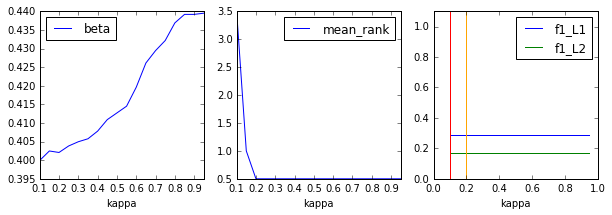

In [172]:
demo(seed_size=1)

100%|██████████| 18/18 [00:14<00:00,  1.11it/s]


min_beta_idx 4
min_rank_idx 6


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


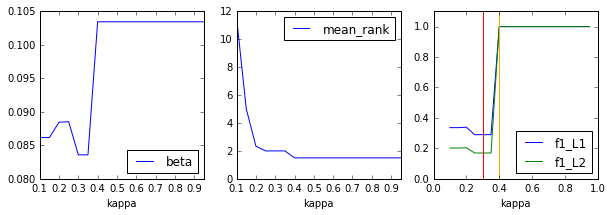

In [149]:
demo(seed_size=3)

100%|██████████| 18/18 [00:13<00:00,  1.39it/s]
/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


min_beta_idx 3
min_rank_idx 12


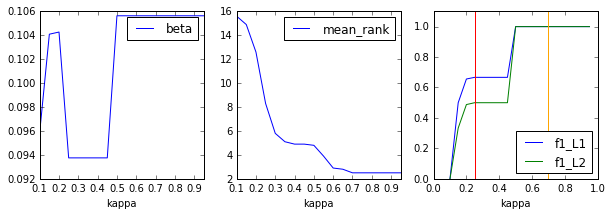

In [146]:
demo(seed_size=5)

100%|██████████| 18/18 [00:13<00:00,  1.39it/s]
/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


min_beta_idx 12
min_rank_idx 17


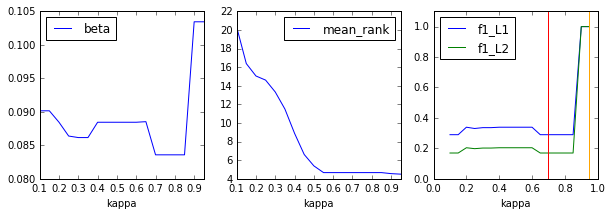

In [147]:
demo(9)

In [184]:
import seaborn as sns

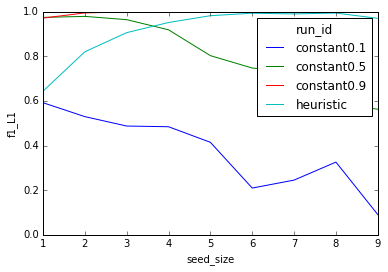

In [193]:
df = pd.read_csv('outputs/kappa_heursitic.csv')
avg_df = df[['f1_L1', 'f1_L2', 'run_id', 'seed_size']].groupby(['seed_size', 'run_id']).mean()
avg_df.reset_index(level=1, inplace=True)
avg_df.reset_index(level=0, inplace=True)

fig, ax = plt.subplots(1, 1)
avg_df.reset_index(level=0, inplace=True)

sns.lineplot(x='seed_size', y='f1_L1', hue='run_id', data=avg_df, markers='-o')
# avg_df.plot(x='seed_size', y=['f1_L1', 'f1_L2'], style=['o-', 'o-'], ax=ax)
# ax.set_title('seed_size VS. f1 score (using theoretical kappa')

# question

- setting $\kappa$ high (e.g, 0.9) does not harm performance in this case? Is it equivalent to say that we should always do that?
  - If the size of ground truth community is large, should we still do that?